# Homework of Week 3

In [14]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Callable
from scipy.integrate import solve_ivp

In [15]:
# %%capture
# %pip install qiskit==1.3.2 pylatexenc
# %pip install qiskit-ibm-runtime==0.35.0
# %pip install qiskit_aer==0.17.0

In [16]:
# Quantum Circuits!
from qiskit import QuantumCircuit
from qiskit import QuantumRegister, ClassicalRegister

# General Imports
from qiskit.primitives import StatevectorSampler
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Noisy simulations
from qiskit_aer import AerSimulator
from qiskit_aer.noise import (
    NoiseModel,
    QuantumError,
    ReadoutError,
    depolarizing_error,
    pauli_error,
    thermal_relaxation_error,
)

# Running on a real quantum computer
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import SamplerV2

# Exercise 1

We want to create the following state using Qiskit, where we say $\ket 0 = \ket \darr$ and $\ket 1 = \ket \uarr$ for example:
$$
\begin{align*}

\ket \psi = \frac1{\sqrt 2}(\ket 0 + i \ket 1)

\end{align*}
$$

We can do that by:
- First applying a Hadamard gate to get an equal superposition of the two states.
- Then applying a S gate to put a phase of $i$ in the component $\ket 1$.

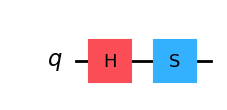

In [17]:
# Make the circuit
qc = QuantumCircuit(1)

qc.h(0)
qc.s(0)

qc.draw('mpl')

In [18]:
# Calculate state at end of circuit
state = Statevector(qc)
state.draw("latex")

<IPython.core.display.Latex object>

# Exercise 2

We construct the desired circuit and use qiskit to calculate the final state vector:
- We apply a Hadamard gate to each of the qubits to put them in an equal superposition state of $\ket 0$ and $\ket 1$.
- We them apply another Hadamard to each qubit and the CNOT gate.

In [19]:
# Make the circuit
qc = QuantumCircuit(2)

qc.h([0, 1])
qc.h([0, 1])
qc.cx(0, 1)

state = Statevector(qc)
state.draw("latex")

<IPython.core.display.Latex object>

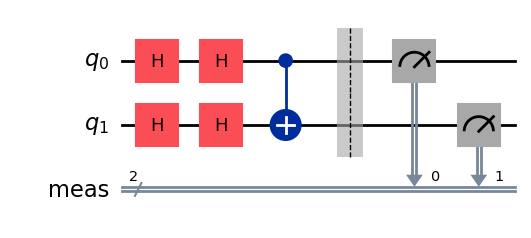

In [20]:
# Calculate state at end of circuit
qc.measure_all()
qc.draw('mpl')

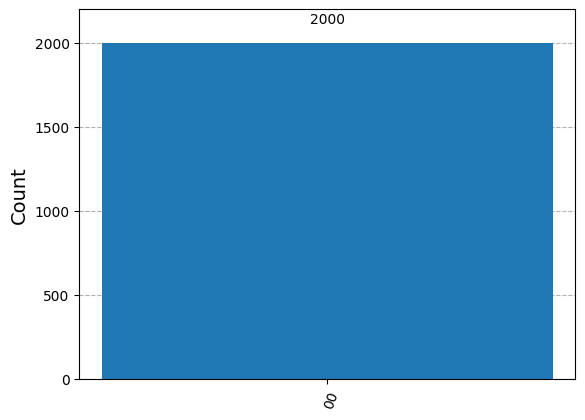

In [21]:
# Making a simulation, using a sampler
sampler = StatevectorSampler()

# Running the job
job = sampler.run([qc], shots=2000)

# The "0" index is because we can run more than one circuit
results = job.result()[0] 

# The "c" attribute is named after the classical register
counts = results.data.meas.get_counts()

# Plot the results
plot_histogram(counts)

This experiment show that:
- If the time-evolution of the system is equivalent to applying a Hadamard gate to each qubit then the superposition state of the qubit self-intereferes destructively, leaving only the state $\ket 0$.
- This is analogous to the double-slit experiment in the sense that in that experiment there are areas of the detector that the particles never hit because they interfere self-destructively.

# Exercise 3

In order to develop a full experiment that allows us to study the evolution of entropy in the system, we will consider a system where:
- We have one noisy qubit.
- We have one noisy single-qubit gate that is an involution.
- We consider a set of circuits where this gate is applied to our circuit 2 times, 4 times, 6 times, etc.


In this way, we expect that, after we measure the state of the qubit at the end:
- If there is no noise the entropy is constant and equal to zero because wherever we measure the qubit it is in state $\ket 0$.
- If there is noise then the entropy of the system will be non-zero because the qubit will be in a superposition of $\ket 0$ and $\ket 1$.

## Entropy Function

In [22]:
def normalise(pp: np.ndarray) -> np.ndarray:
    """    
    Normalizes probability vector for a set of discrete random variables.

    Args:
        pp: Input vector.

    Returns:
        float: Valid probability vector.
    """

    return pp / np.sum(pp)


def entropy(pp: np.ndarray, b: int = 2) -> float:
    """    
    Calculates entropy for a discrete random variable (or joint entropies for more random variables).

    Args:
        pp: Probability vector.
        b: Log base.

    Returns:
        float: Entropy.
    """

    # Probability 0 events contribute zero to the entropy
    pp = pp[pp > 0] 

    # Entropy
    return -np.sum(pp * np.log(pp) / np.log(b))

In [23]:
def entropy_of_noise(noise_model, gate_tested: str, gate_min: int = 0, gate_max: int = 30):

    # Create noisy simulator backend
    sim_noise = AerSimulator(noise_model=noise_model)
    
    # Transpile circuit for noisy basis gates
    passmanager = generate_preset_pass_manager(
        optimization_level=3, backend=sim_noise
    )

    ee = []
    oo = np.arange(gate_min, gate_max, 2)
    for index in oo:
        # Make the circuit
        qc = QuantumCircuit(1)

        # Put the gates, we use barriers to prevent the transpiler from noticing that involution gates cancel out
        for _ in range(index):
            getattr(qc, gate_tested)(0)
            qc.barrier()

        qc.measure_all()
        
        qc_noisy = passmanager.run(qc)
        
        # Run and get counts
        result = sim_noise.run(qc_noisy).result()
        counts = result.get_counts()

        # Save entropy
        ee += [entropy(normalise(np.array([counts.get('0', 0), counts.get('1', 0)])))]

    plt.title(f"Entropy vs. Number of Applications of Gate {gate_tested.upper()}")
    plt.plot(oo, ee)
    plt.xlabel("Number of Operations")
    plt.ylabel("Entropy/ Bits")
    plt.show()

## Bit Flips

In [24]:
# Error probabilities
p_reset = 0.0001
p_meas = 0.0001
p_gate = 0.015

# QuantumError objects
error_reset = pauli_error([('X', p_reset), ('I', 1 - p_reset)])
error_meas = pauli_error([('X', p_meas), ('I', 1 - p_meas)])
error_gate = pauli_error([('X', p_gate), ('I', 1 - p_gate)])

# Add errors to noise model
noise_bit_flip = NoiseModel()
noise_bit_flip.add_all_qubit_quantum_error(error_reset, "reset")
noise_bit_flip.add_all_qubit_quantum_error(error_meas, "measure")
noise_bit_flip.add_all_qubit_quantum_error(error_gate, ["h", "x", "y", "z"])

1.0


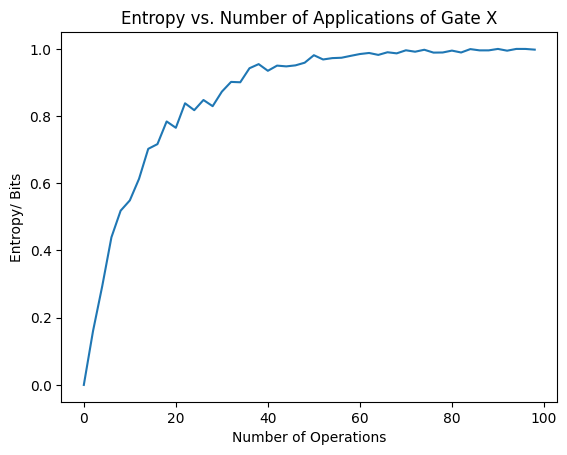

In [25]:
print(-np.log(0.5) / np.log(2))
entropy_of_noise(noise_bit_flip, "x", gate_max = 100)

We see that the entropy increases towards the maximum value possible of $1$ as we increase the number of gates, which is expected because adding more gates corresponds to adding more noise to the system!

## Real Noise Profile

In [ ]:
# Initiate connection
TOKEN = ""
service = QiskitRuntimeService(channel="ibm_quantum", token=TOKEN)

# Choose a real quantum computer, which is not busy
backend = service.least_busy(operational=True, simulator=False)
print(f"{backend.name =}, {backend.num_qubits = }")

# Get noise profile
noise_real = NoiseModel.from_backend(backend)

backend.name ='ibm_brisbane', backend.num_qubits = 127


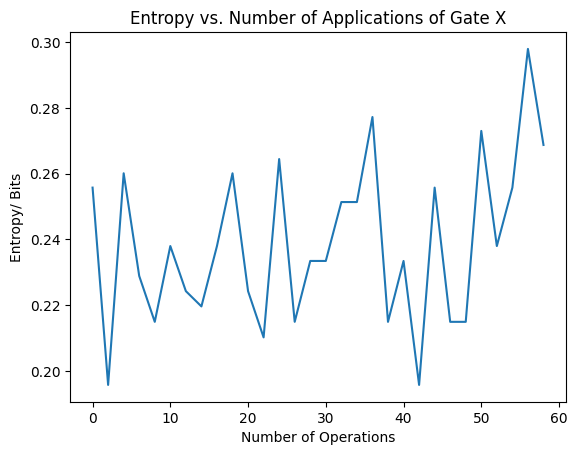

In [36]:
entropy_of_noise(noise_real, "x", 0, 60)

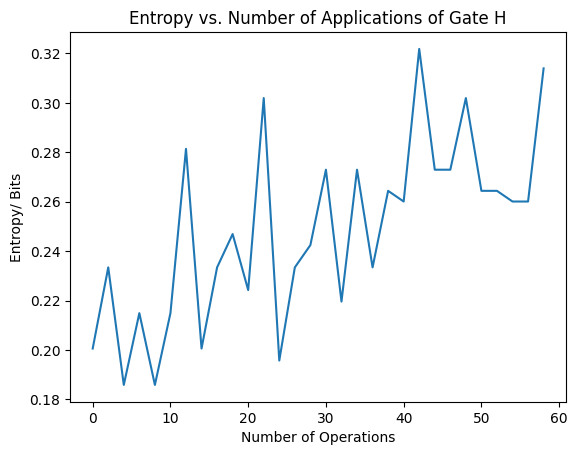

In [37]:
entropy_of_noise(noise_real, "h", 0, 60)

# Exercise 4

In [29]:
# We setup a circuit
qc = QuantumCircuit(1)

# Put the gates, we use barriers to prevent the transpiler from noticing that involution gates cancel out
for _ in range(20):
    getattr(qc, "x")(0)
    qc.barrier()

qc.measure_all()

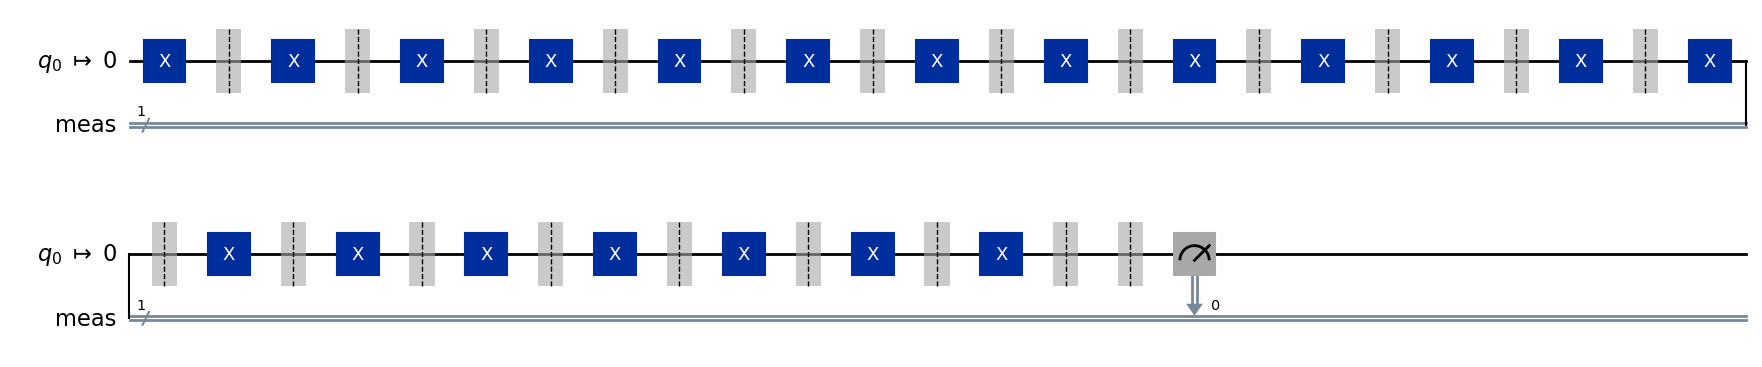

In [30]:
# We use the least busy backend we found above
pass_manager = generate_preset_pass_manager(
    backend=backend,
    optimization_level=1
)

# Transpile circuit
tqc = pass_manager.run(qc)
tqc.draw('mpl', idle_wires=False)

In [31]:
# Sampler of results
sampler = SamplerV2(backend)

# Set the job to run
job = sampler.run([tqc], shots=128)
job.job_id()

'd0caf1wqnmvg0087kesg'

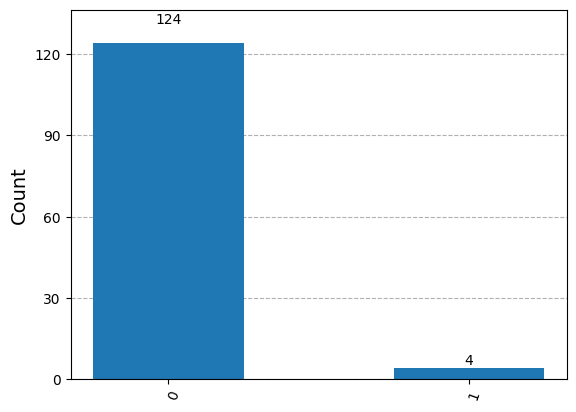

In [32]:
# After the job ends, see the results
results = job.result()[0]
counts = results.data.meas.get_counts()

plot_histogram(counts)

In [33]:
# We calculate the entropy
print(f"Entropy for the results: {entropy(normalise(counts))}")

TypeError: unsupported operand type(s) for /: 'dict' and 'dict'

We see that the entropy is higher than the value predicted by the simulator!